In [1]:
import numpy as np
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

from lim_mod_pt import LIM

from read_AM_index_mod import Reanalysis, CMIP6

import torch
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

from torch import linalg as la

with open("model_list.txt", "r") as f:
    model_list = f.readlines()
    model_list = [d.replace("\n", "") for d in model_list]
# model_list.remove("CESM2")
# model_list.remove("CESM2-WACCM")
# model_list.remove("HadGEM3-GC31-LL")
# model_list.remove("HadGEM3-GC31-MM")
# model_list.remove("KACE")
# model_list.remove("UKESM1")

plev = [1000.,  850.,  700.,  500.,  250.,  100.,   50.,   10.]

In [2]:
D0 = Reanalysis(name_dir='jra_55', year_start=1958, year_end=2014, plev=plev, name='JRA55', \
        annual_cycle_fft=4, running_mean=0, save_index=False)
# D0 = Reanalysis(name_dir='jra_55', year_start=1958, year_end=2014, name='JRA55', \
#         annual_cycle_fft=4, running_mean=0, save_index=False)

D0.y, _ = D0.slice_data(month_start=11, len_slice=150, month_start2=8)
D0.y = torch.from_numpy(D0.y.astype('float32'))
# D0.y = torch.from_numpy(D0.y.astype('float64'))
print(D0.name)

t = torch.linspace(0, D0.y.shape[1]-1, D0.y.shape[1], dtype=D0.y.dtype)
p = D0.level
print(f't.shape = {t.shape}, y.shape = {D0.y.shape}')

Reading from saved data ......
JRA55
t.shape = torch.Size([150]), y.shape = torch.Size([56, 150, 8])


In [57]:
def visualization():
    y = D0.y

    model = LIM(y, hyp_param, verbose=True)
    print(model.vl.shape)

    # forecasting
    forecast_time = 40
    yf = model.forecast(y[:, :-forecast_time, :], t[:forecast_time+1])
    sn = np.sign(model.vr[np.isin(p, 10), 0].real)
    print(f'y.shape={y.shape}, yf.shape={yf.shape}')

    # plotting vr, vl
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1,2,1)
    plt.plot(model.vr[:, 0].real*sn, p, label='Real')
    plt.plot(model.vr[:, 0].imag*sn, p, label='Imag')
    plt.plot(p*0, p, '--k')

    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.legend()

    ax = fig.add_subplot(1,2,2)
    plt.plot(model.vl[:, 0].real*sn, p, label='Real')
    plt.plot(model.vl[:, 0].imag*sn, p, label='Imag')
    plt.plot(p*0, p, '--k')

    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.legend()

    # # finding and plotting optimals
    # rr = np.ones((len(p), 1))
    # rr [p<200] = 0
    # print(rr)
    # N = torch.from_numpy((rr @ rr.T).astype('float32'))
    N = torch.eye(len(p))
    print(f'N.shape={N.shape}')
    
    # w, vr = model.optimals(t[:forecast_time+1], method='eig', N=N)

    # fig = plt.figure(figsize=(12, 5))
    # ax = fig.add_subplot(1,2,1)
    # plt.plot(vr[forecast_time, :], p, label='V')
    # plt.plot(p*0, p, '--k')
    # plt.gca().invert_yaxis()
    # plt.ylabel('Pressure (hPa)')
    # plt.yscale('log')
    # plt.yticks([10, 30, 100, 300, 1000])
    # plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    # plt.legend()

    # ax = fig.add_subplot(1,2,2)
    # plt.plot(w)
    # print(f'Amplification =\n{w}')

    U, s, V = model.optimals(t[:forecast_time+1], method='svd')
    sn = np.sign(U[forecast_time, np.isin(p, 10)])

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1,2,1)
    plt.plot(U[forecast_time, :]*sn, p, label='U')
    plt.plot(V[forecast_time, :]*sn, p, label='V')
    plt.plot(p*0, p, '--k')
    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.legend()

    ax = fig.add_subplot(1,2,2)
    plt.plot(s**2)
    print(f'Amplification =\n{s**2}')


hyperpamameters:
{'lim': {'lag_time': 5, 'method': 'DMD', 'LIM': {'r_optimal': None}, 'DMD': {'r_alpha': 1, 'r_optimal': None, 'r_forecast': 5}}}
r_opt=5: % of var=99.97969055175781, B_norm=0.3434509336948395, X_err=185.57078552246094, s=1.095610499382019
POP e-folding timescales =
 tensor([23.3919, 23.3919, 10.4264,  7.3009,  4.4967])
torch.Size([8, 5])
y.shape=torch.Size([56, 150, 8]), yf.shape=torch.Size([56, 41, 110, 8])
N.shape=torch.Size([8, 8])
Amplification =
tensor([1.0000, 1.0399, 1.0806, 1.1214, 1.1615, 1.2004, 1.2373, 1.2717, 1.3034,
        1.3318, 1.3569, 1.3784, 1.3962, 1.4101, 1.4203, 1.4265, 1.4290, 1.4276,
        1.4225, 1.4137, 1.4015, 1.3860, 1.3672, 1.3455, 1.3211, 1.2941, 1.2649,
        1.2335, 1.2004, 1.1657, 1.1296, 1.0925, 1.0546, 1.0159, 0.9769, 0.9377,
        0.8984, 0.8592, 0.8204, 0.7820, 0.7441])


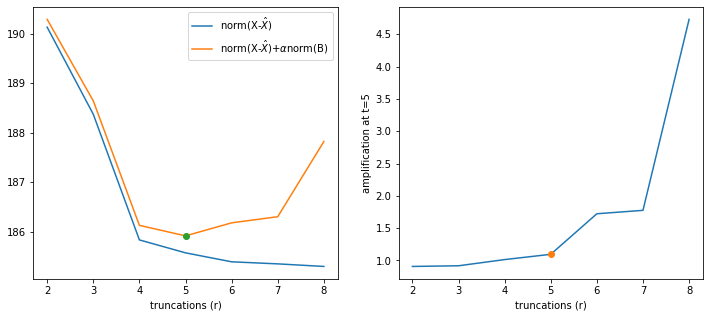

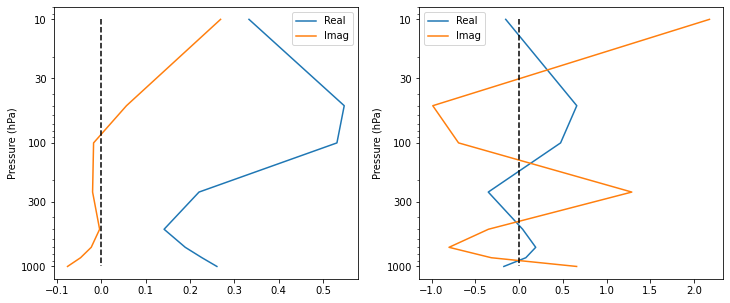

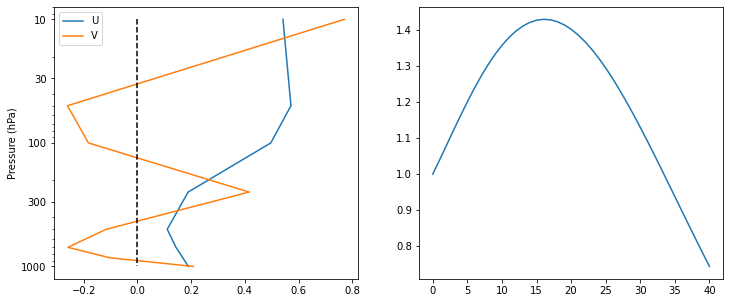

In [58]:
hyp_param = dict(lim = dict(lag_time = 5,
                            method = 'DMD',
                            LIM = dict( r_optimal = None,
                                        ),
                            DMD = dict( r_alpha = 1,
                                        r_optimal = None,
                                        r_forecast = 5,
                                       )
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

visualization()

hyperpamameters:
{'lim': {'lag_time': 5, 'method': 'DMD', 'LIM': {'r_optimal': None}, 'DMD': {'r_alpha': 1, 'r_optimal': 5, 'r_forecast': 5}}}
r_opt=5: % of var=99.97969055175781, B_norm=0.3434509336948395, X_err=185.57078552246094, s=1.095610499382019
POP e-folding timescales =
 tensor([23.3919, 23.3919, 10.4264,  7.3009,  4.4967])
torch.Size([8, 5])
y.shape=torch.Size([56, 150, 8]), yf.shape=torch.Size([56, 41, 110, 8])
N.shape=torch.Size([8, 8])
Amplification =
tensor([1.0000, 1.0399, 1.0806, 1.1214, 1.1615, 1.2004, 1.2373, 1.2717, 1.3034,
        1.3318, 1.3569, 1.3784, 1.3962, 1.4101, 1.4203, 1.4265, 1.4290, 1.4276,
        1.4225, 1.4137, 1.4015, 1.3860, 1.3672, 1.3455, 1.3211, 1.2941, 1.2649,
        1.2335, 1.2004, 1.1657, 1.1296, 1.0925, 1.0546, 1.0159, 0.9769, 0.9377,
        0.8984, 0.8592, 0.8204, 0.7820, 0.7441])


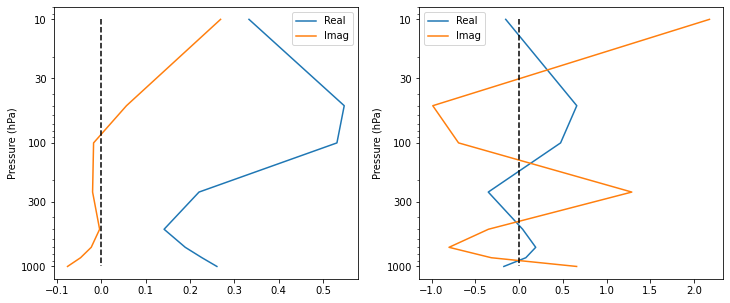

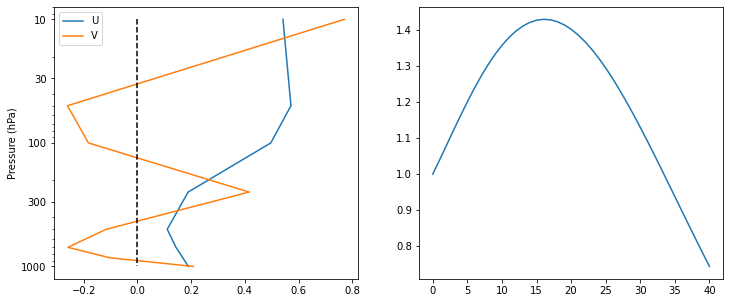

In [69]:
hyp_param = dict(lim = dict(lag_time = 5,
                            method = 'DMD',
                            LIM = dict( r_optimal = None,
                                        ),
                            DMD = dict( r_alpha = 1,
                                        r_optimal = 5,
                                        r_forecast = 5,
                                       )
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

visualization()